# 一、前期工作

本文将采用CNN实现多云、下雨、晴、日出四种天气状态的识别。较上篇文章，本文为了增加模型的泛化能力，新增了Dropout层并且将最大池化层调整成了平均池化层。

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1Viq7s2FEtmcQQ3sRTMhszg （提取码：hqij ）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2

**来自专栏：**[**【深度学习100例】**](https://blog.csdn.net/qq_38251616/category_11068756.html)

## 1. 设置GPU

如果使用的是CPU可以忽略这步

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0]                                        #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")

## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

import pathlib

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/weather_photos/"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

数据集一共分为`cloudy`、`rain`、`shine`、`sunrise`四类，分别存放于`weather_photos`文件夹中以各自名字命名的子文件夹中。

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))

print("图片总数为：",image_count)

图片总数为： 1125


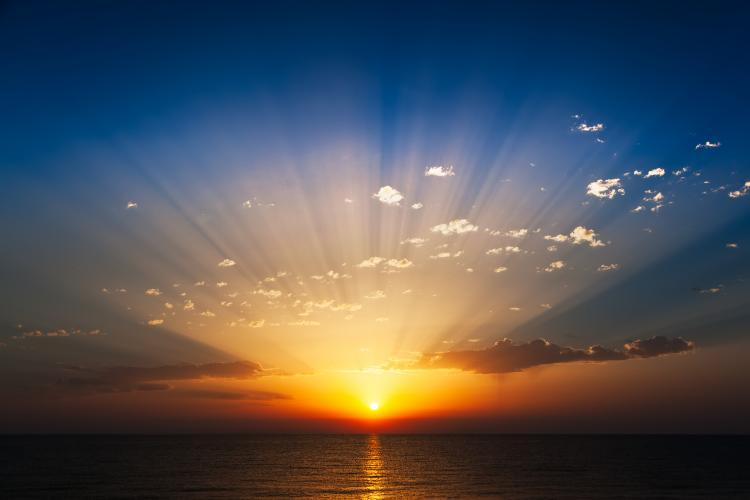

In [5]:
roses = list(data_dir.glob('sunrise/*.jpg'))
PIL.Image.open(str(roses[0]))

# 二、数据预处理

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 900 files for training.


In [8]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 225 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [9]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'rain', 'shine', 'sunrise']


## 2. 可视化数据

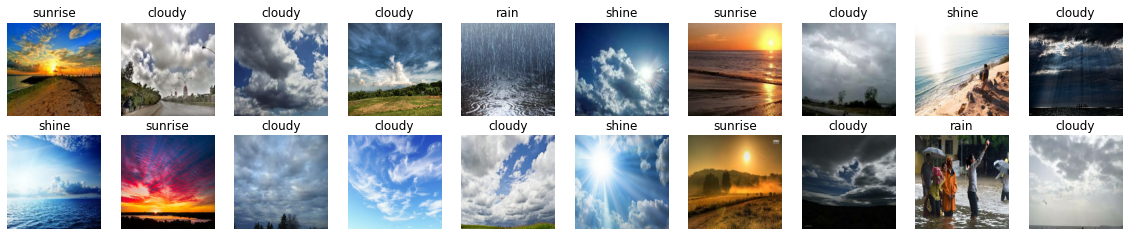

In [10]:
plt.figure(figsize=(20, 10))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 10, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

## 3. 再次检查数据 

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


- `Image_batch`是形状的张量（32,180,180,3）。这是一批形状180x180x3的32张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（32，）的张量，这些标签对应32张图片

## 4. 配置数据集

- **shuffle()**：打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()**：预取数据，加速运行

`prefetch()`功能详细介绍：CPU 正在准备数据时，加速器处于空闲状态。相反，当加速器正在训练模型时，CPU 处于空闲状态。因此，训练所用的时间是 CPU 预处理时间和加速器训练时间的总和。`prefetch()`将训练步骤的预处理和模型执行过程重叠到一起。当加速器正在执行第 N 个训练步时，CPU 正在准备第 N+1 步的数据。这样做不仅可以最大限度地缩短训练的单步用时（而不是总用时），而且可以缩短提取和转换数据所需的时间。如果不使用`prefetch()`，CPU 和 GPU/TPU 在大部分时间都处于空闲状态：

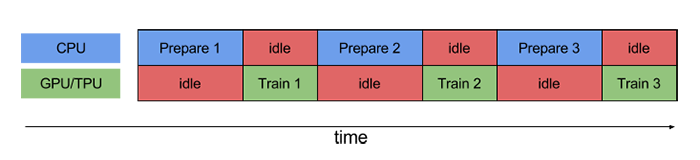

使用`prefetch()`可显著减少空闲时间：

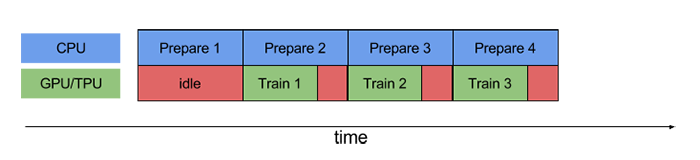

- **cache()**：将数据集缓存到内存当中，加速运行

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 三、构建CNN网络

卷积神经网络（CNN）的输入是张量 (Tensor) 形式的 `(image_height, image_width, color_channels)`，包含了图像高度、宽度及颜色信息。不需要输入`batch size`。color_channels 为 (R,G,B) 分别对应 RGB 的三个颜色通道（color channel）。在此示例中，我们的 CNN 输入，fashion_mnist 数据集中的图片，形状是 `(28, 28, 1)`即灰度图像。我们需要在声明第一层时将形状赋值给参数`input_shape`。

In [13]:
num_classes = 4

"""
关于卷积核的计算不懂的可以参考文章：https://blog.csdn.net/qq_38251616/article/details/114278995

layers.Dropout(0.4) 作用是防止过拟合，提高模型的泛化能力。
在上一篇文章花朵识别中，训练准确率与验证准确率相差巨大就是由于模型过拟合导致的

关于Dropout层的更多介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/115826689
"""

model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 卷积层1，卷积核3*3  
    layers.AveragePooling2D((2, 2)),               # 池化层1，2*2采样
    layers.Conv2D(32, (3, 3), activation='relu'),  # 卷积层2，卷积核3*3
    layers.AveragePooling2D((2, 2)),               # 池化层2，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层3，卷积核3*3
    layers.Dropout(0.3),  
    
    layers.Flatten(),                       # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'),   # 全连接层，特征进一步提取
    layers.Dense(num_classes)               # 输出层，输出预期结果
])

model.summary()  # 打印网络结构

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 41, 41, 64)        0

# 四、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [14]:
# 设置优化器
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 五、训练模型

In [15]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 6s 58ms/step - loss: 1.5865 - accuracy: 0.4463 - val_loss: 0.5837 - val_accuracy: 0.7689
Epoch 2/10
29/29 [==============================] - 0s 12ms/step - loss: 0.5289 - accuracy: 0.8295 - val_loss: 0.5405 - val_accuracy: 0.8133
Epoch 3/10
29/29 [==============================] - 0s 12ms/step - loss: 0.2930 - accuracy: 0.8967 - val_loss: 0.5364 - val_accuracy: 0.8000
Epoch 4/10
29/29 [==============================] - 0s 12ms/step - loss: 0.2742 - accuracy: 0.9074 - val_loss: 0.4034 - val_accuracy: 0.8267
Epoch 5/10
29/29 [==============================] - 0s 11ms/step - loss: 0.1952 - accuracy: 0.9383 - val_loss: 0.3874 - val_accuracy: 0.8844
Epoch 6/10
29/29 [==============================] - 0s 11ms/step - loss: 0.1592 - accuracy: 0.9468 - val_loss: 0.3680 - val_accuracy: 0.8756
Epoch 7/10
29/29 [==============================] - 0s 12ms/step - loss: 0.0836 - accuracy: 0.9755 - val_loss: 0.3429 - val_accuracy: 0.8756
Epoch 8/10
29

# 六、模型评估

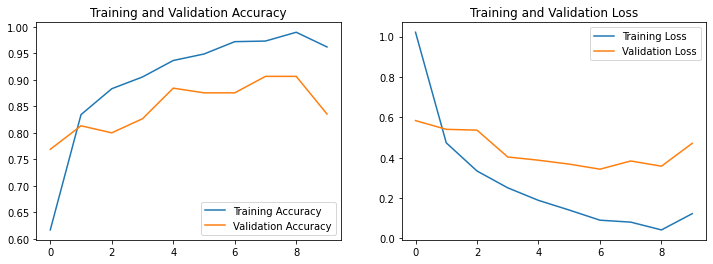

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**其他精彩内容：**

- [**深度学习100例-卷积神经网络（CNN）实现mnist手写数字识别 | 第1天**](https://mtyjkh.blog.csdn.net/article/details/116920825)
- [**深度学习100例-卷积神经网络（CNN）彩色图片分类 | 第2天**](https://mtyjkh.blog.csdn.net/article/details/116978213)
- [**深度学习100例-卷积神经网络（CNN）服装图像分类 | 第3天**](https://mtyjkh.blog.csdn.net/article/details/116992196)
- [**深度学习100例-卷积神经网络（CNN）花朵识别 | 第4天**](https://mtyjkh.blog.csdn.net/article/details/117079919)

**《深度学习100例》专栏直达：**[**【传送门】**](https://blog.csdn.net/qq_38251616/category_11068756.html)

思考：1.最大池化与平均池化的区别是什么呢？2.学习率是不是越大越好，优化器该如何设置呢？

需要数据的同学可以在评论中留下邮箱